In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm.auto import trange

from torchinfo import summary

print(torch.__version__)

1.10.0+cu102


In [2]:
batch_size = 50
learning_rate = 0.0002
num_epoch = 100

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(cifar10_train,batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar10_test,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(classes))

10


## Visualizing CIFAR10

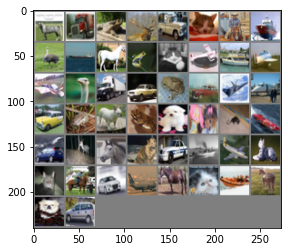

horse truck  frog  deer truck   cat horse  ship  bird  ship horse  frog   cat plane  ship plane plane  bird truck   car  frog   car plane plane   car  frog   dog  frog   dog   dog   cat  ship   car  deer horse   cat   car  ship plane   cat   cat horse   car plane horse   cat  ship horse   dog   car


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## ResNet(Manual)

## 1-1) Basic Module

In [8]:
def conv_block_1(in_dim,out_dim,act_fn,stride=1):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=1, stride=stride),
        act_fn,
    )
    return model


def conv_block_3(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        act_fn,
    )
    return model

## 1-2) Bottleneck Module

In [9]:
class BottleNeck(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,act_fn,down=False):
        super(BottleNeck,self).__init__()
        self.down=down
        
        # 특성지도의 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_dim,mid_dim,act_fn,2),
              conv_block_3(mid_dim,mid_dim,act_fn),
              conv_block_1(mid_dim,out_dim,act_fn),
            )
            self.downsample = nn.Conv2d(in_dim,out_dim,1,2)
            
        # 특성지도의 크기가 그대로인 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_dim,mid_dim,act_fn),
                conv_block_3(mid_dim,mid_dim,act_fn),
                conv_block_1(mid_dim,out_dim,act_fn),
            )
            
        # 더하기를 위해 차원을 맞춰주는 부분
        self.dim_equalizer = nn.Conv2d(in_dim,out_dim,kernel_size=1)
                  
    def forward(self,x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out


## 2) Define Model & Optimizer & Loss

In [10]:
class ResNet(nn.Module):

    def __init__(self, base_dim, num_classes=10):
        super(ResNet, self).__init__()
        self.act_fn = nn.ReLU()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(base_dim,base_dim,base_dim*4,self.act_fn),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn),
            BottleNeck(base_dim*4,base_dim,base_dim*4,self.act_fn,down=True),
        )   
        self.layer_3 = nn.Sequential(
            BottleNeck(base_dim*4,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck(base_dim*8,base_dim*2,base_dim*8,self.act_fn,down=True),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(base_dim*8,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),            
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck(base_dim*16,base_dim*4,base_dim*16,self.act_fn,down=True),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(base_dim*16,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
        )
        self.avgpool = nn.AvgPool2d(1,1) 
#         self.avgpool = nn.AvgPool2d(7,1) 
        self.fc_layer = nn.Linear(base_dim*32,num_classes)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        
        return out


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
model = ResNet(base_dim=64).to(device)

for i in model.children():
    print(i)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

cuda:0
ReLU()
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)
Sequential(
  (0): BottleNeck(
    (layer): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (dim_equalizer): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): BottleNeck(
    (layer): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequent

In [12]:
# # model summary
summary(model, (batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Sequential: 1-1                        [50, 64, 8, 8]            --
│    └─Conv2d: 2-1                       [50, 64, 16, 16]          9,472
│    └─ReLU: 2-2                         [50, 64, 16, 16]          --
│    └─MaxPool2d: 2-3                    [50, 64, 8, 8]            --
├─Sequential: 1-2                        [50, 256, 4, 4]           --
│    └─BottleNeck: 2-4                   [50, 256, 8, 8]           --
│    │    └─Sequential: 3-1              [50, 256, 8, 8]           57,728
├─ReLU: 1-3                              [50, 64, 8, 8]            --
├─ReLU: 1-4                              [50, 64, 8, 8]            --
├─ReLU: 1-5                              [50, 256, 8, 8]           --
├─Sequential: 1                          --                        --
│    └─BottleNeck: 2                     --                        --
│    │  

## 3) TRAIN

In [13]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(1.6044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0224, device='cuda:0', grad_fn=<NllLossBackward0>)



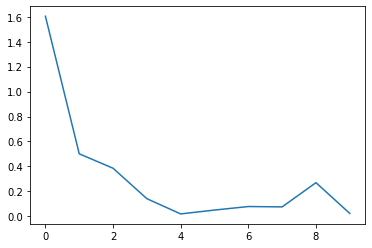

In [14]:
plt.plot(loss_arr)
plt.show()

## 4) TEST

In [15]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        
        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)
        #print(len(_), _) #values
        #print(len(output_index), output_index) #indices
        
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y).sum().float()
    
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 73.62999725341797%
